# Foundations of Time Series Analysis

This notebook presents a professional, concept-driven analysis of time series data.
It has been refactored from academic material into a portfolio-ready project,
focused on clarity, statistical reasoning, and reproducibility.


In [ ]:
#!pip install darts
#%pip install pmdarima

In [ ]:
import numpy as np
import pandas as pd
from darts import TimeSeries
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox

import pmdarima as pm
from darts.models import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller


from darts.utils.statistics import plot_acf, plot_pacf, acf, pacf

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [278]:
apple_data = yf.download('AAPL', start='2016-01-01', end='2025-05-30', interval = '1mo', progress=False)
df = apple_data['Close'].rename(columns={'Close': 'AAPL'})
display(df)
df.columns
df.info()

Ticker,AAPL
Date,
2016-01-01,21.993353
2016-02-01,21.846493
2016-03-01,24.759224
2016-04-01,21.294888
2016-05-01,22.685163
...,...
2025-01-01,235.432083
2025-02-01,241.258011
2025-03-01,221.839096


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113 entries, 2016-01-01 to 2025-05-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    113 non-null    float64
dtypes: float64(1)
memory usage: 1.8 KB


In [279]:
# Asegurarse de que el índice es datetime
df.index = pd.to_datetime(df.index)
type(df['AAPL'])

pandas.core.series.Series

In [280]:
#Guardarmos en un objeto 'apple_series' que debe ser del tipo series de tiempo pero de 'darts'
apple_series = TimeSeries.from_series(df['AAPL'])
#Dividimos la serie de tiempo en un conjunto de entrenamiento y validación
apple_train, apple_val = apple_series.split_before(pd.Timestamp('2024-10-01'))
type(apple_series)

darts.timeseries.TimeSeries

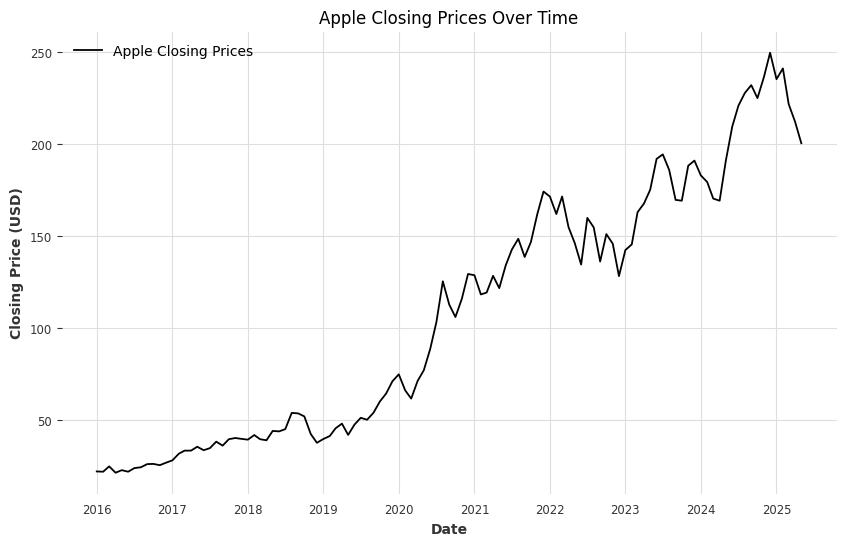

In [281]:
#Graficamos la serie temporal
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['AAPL'], label='Apple Closing Prices')
plt.title('Apple Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

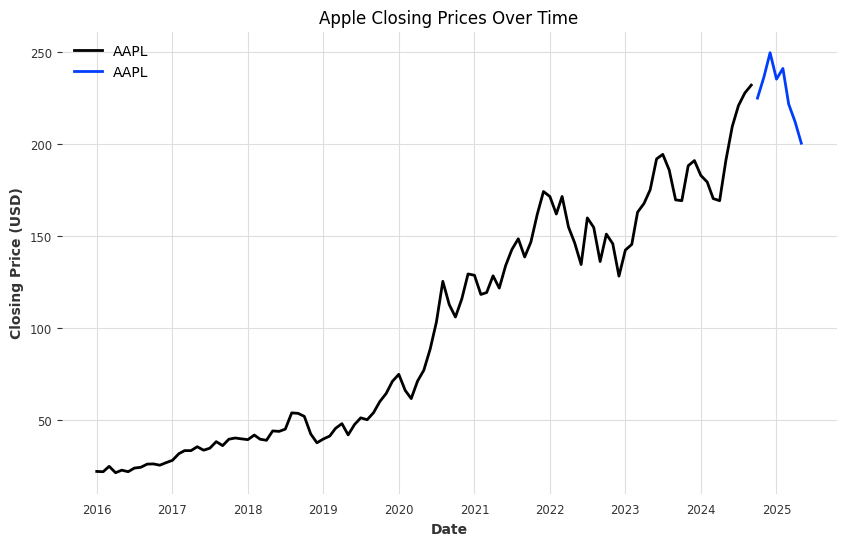

In [282]:
#Graficamos la serie temporal con los datos de entrenamiento y validación
plt.figure(figsize=(10, 6))
apple_train.plot()
apple_val.plot()
plt.title('Apple Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [283]:
#apple_train_pd = apple_train.pd_series() # tener cuidado de acuerdo la versión que se maneja en Python
apple_train_np = apple_train.values().squeeze()# squeeze elimina dimensiones que no son necesarias de un DF o serie
apple_train_pd = pd.DataFrame(apple_train_np)
apple_val_np = apple_val.values().squeeze()
apple_val_pd = pd.DataFrame(apple_val_np)

# Ajuste del modelo ARIMA
## Función auto_arima


In [284]:
mod0 = pm.auto_arima(apple_train_pd)

In [285]:
mod0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -368.572
Date:                Wed, 11 Jun 2025   AIC                            745.145
Time:                        20:23:31   BIC                            755.722
Sample:                             0   HQIC                           749.430
                                - 105                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.2123      0.849      2.606      0.009       0.549       3.876
ar.L1          0.1216      0.076      1.603      0.109      -0.027       0.270
ar.L2         -0.2224      0.073     -3.048      0.002      -0.365      -0.079
sigma2        70.0343      9.256      7.566      0.000      51.893      88.176
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.01
Prob(Q):                              0.97   Prob(JB):                         0.60
Heteroskedasticity (H):              11.80   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Test de Ljung-Box

$H_0:$ Hay ruido blanco

$H_1:$ No hay ruido blanco

Test de Jarque Bera

$H_0:$ Pertenecen a una distribución Normal

$H_1:$ No pertenecen a una distribución Normal

Test de Homocedasticidad

$H_0:$ Son homocedasticos

$H_1:$ No son homocedasticos

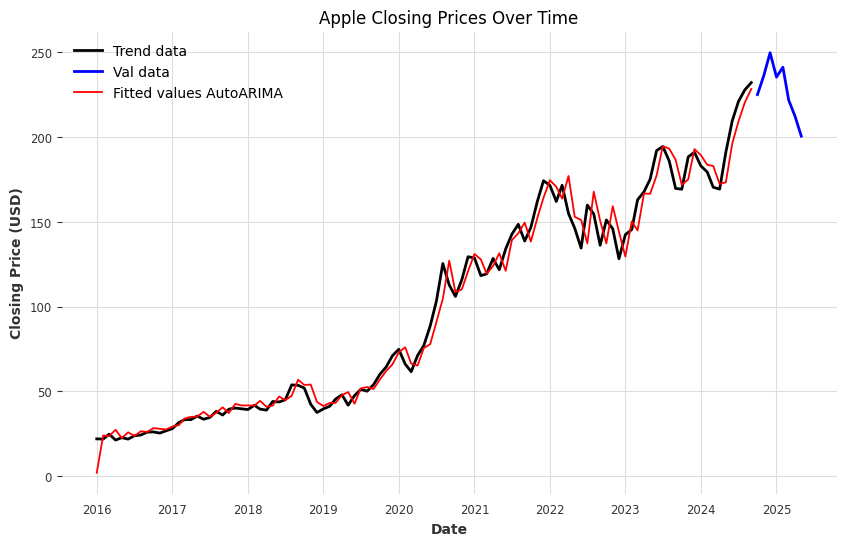

In [286]:
#Graficamos la serie temporal con los datos de entrenamiento y validación
plt.figure(figsize=(10, 6))
apple_train.plot(color='black', label='Trend data')
apple_val.plot(color = 'blue', label='Val data')
plt.plot(df.index[:105], mod0.fittedvalues(), label = 'Fitted values AutoARIMA', color = 'red' )
plt.title('Apple Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [287]:
type(mod0)

pmdarima.arima.arima.ARIMA

In [293]:
pred0 = mod0.predict(n_periods=8)
pred0_pd = pd.DataFrame(pred0.values)

In [290]:
MSE0 = np.square(apple_val_pd-pred0_pd).mean()
rmse0 = np.sqrt(MSE0)
rmse0

0    22.190807
dtype: float64

In [291]:
np.sqrt(mean_squared_error(apple_val_pd, pred0_pd))

22.190807065725146

In [292]:
len(pred0_pd)

8

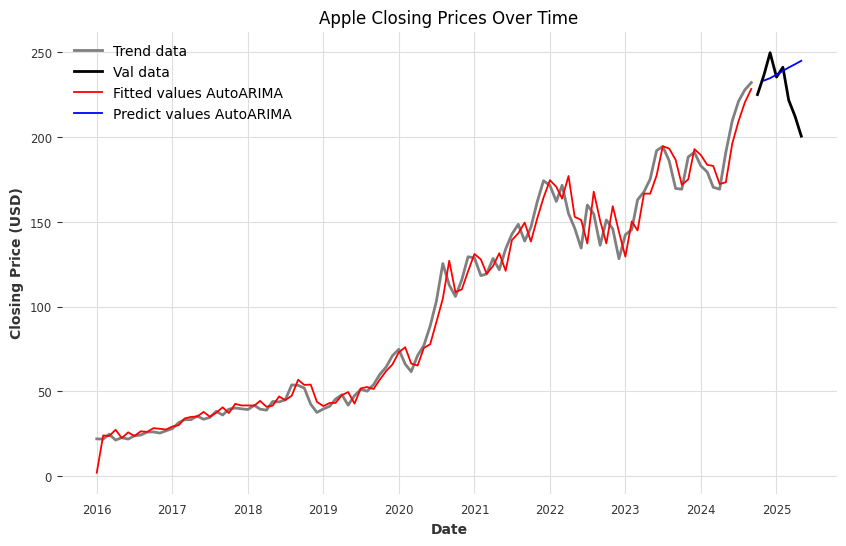

In [294]:
#Graficamos la serie temporal con los datos de entrenamiento y validación
plt.figure(figsize=(10, 6))
apple_train.plot(color='gray', label='Trend data')
apple_val.plot(color = 'black', label='Val data')
plt.plot(df.index[:105], mod0.fittedvalues(), label = 'Fitted values AutoARIMA', color = 'red' )
plt.plot(df.index[106:], pred0_pd[:7], label = 'Predict values AutoARIMA', color='blue')
plt.title('Apple Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Ajuste de un modelo ARIMA mediante ACF y PACF
SARIMAX(p,d,q)

p: parámetro autorregresivo

d: parámetro integrada

q: parámetro media movil

Test de Dicker-Fuller

$H_0:\phi=1$, existe raíz unitaria en la serie (no es estacionaria)

$H_1:\phi<1$, no existe raíz unitaria en la serie (es estacionaria)

In [295]:
adf0 = adfuller(apple_train_pd, 24)
print(adf0[1])

0.9879036845608924


Decisión: No se rechaza la $H_0$, no hay evidencia estadística para decir que la serie no tiene raíz unitaria o no es estacionaria.

Es importante mencionar que está en riesgo el supuesto de invertibilidad.

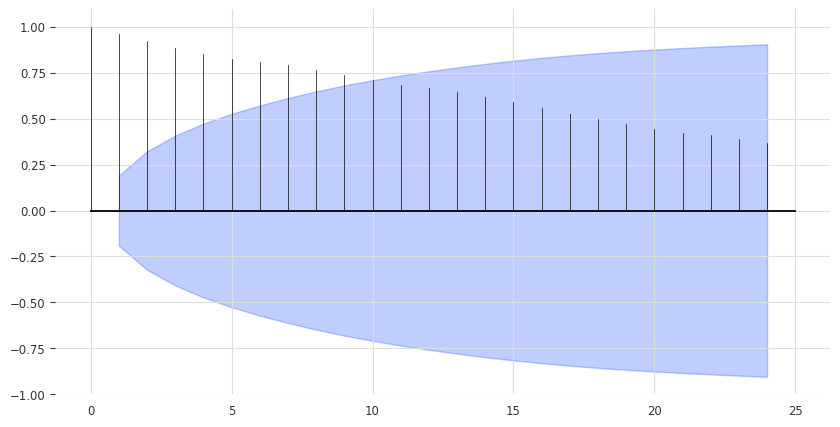

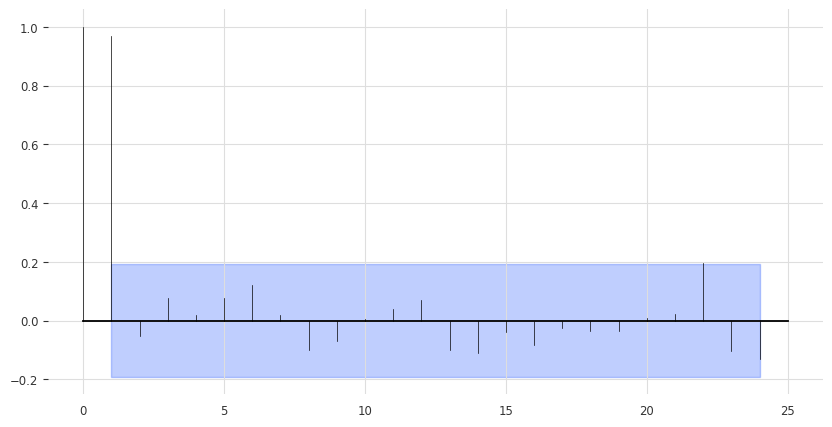

In [296]:
plot_acf(apple_train)
plot_pacf(apple_train)

In [297]:
apple_train_diff1 = apple_train.diff()
apple_train_diff1_pd=pd.DataFrame(apple_train_diff1.values().squeeze())
#apple_train_diff1_pd = apple_train_diff1.pd_series()

In [298]:
adf1 = adfuller(apple_train_diff1_pd, 24)
print(adf1[1])

2.3595355315587155e-13


Decisión: Se rechaza la $H_0$, hay evidencia estadística para decir que la serie no tiene raíz unitaria o es estacionaria.

Es importante mencionar que no está en riesgo el supuesto de invertibilidad.

## ACF y PACF
ACF: Función de autocorrelación.
PACF: Función de autocorrelación parcial.

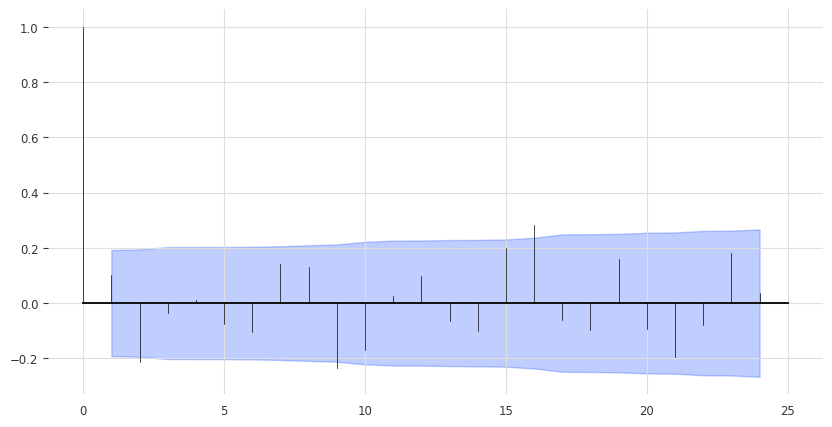

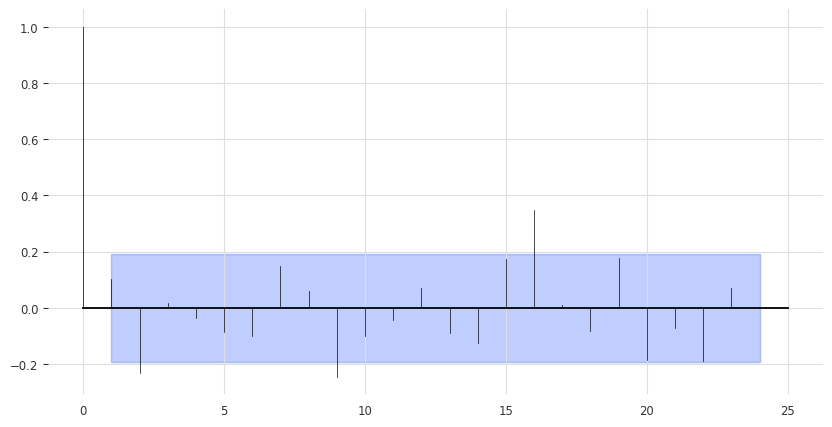

In [299]:
plot_acf(apple_train_diff1) # me ayuda a seleccionar el parámetro q del ARIMA(p,d,q)
plot_pacf(apple_train_diff1) # me ayuda a seleccionar el parámetro p del ARIMA(p,d,q)

In [300]:
mod1 = SARIMAX(apple_train_pd, order = (2, 1, 2), seasonal_order = (0, 0, 0, 0)).fit(disp=0)
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      0   No. Observations:                  105
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -369.219
Date:                Wed, 11 Jun 2025   AIC                            748.437
Time:                        20:50:55   BIC                            761.659
Sample:                             0   HQIC                           753.794
                                - 105                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1761      0.053     -3.292      0.001      -0.281      -0.071
ar.L2         -0.9578      0.063    -15.190      0.000      -1.081      -0.834
ma.L1          0.2410      0.091      2.642      0.008       0.062       0.420
ma.L2          0.9044      0.092      9.878      0.000       0.725       1.084
sigma2        70.4325     10.153      6.937      0.000      50.532      90.333
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                 0.51
Prob(Q):                              0.50   Prob(JB):                         0.78
Heteroskedasticity (H):              14.31   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [301]:
len(mod1.fittedvalues)

105

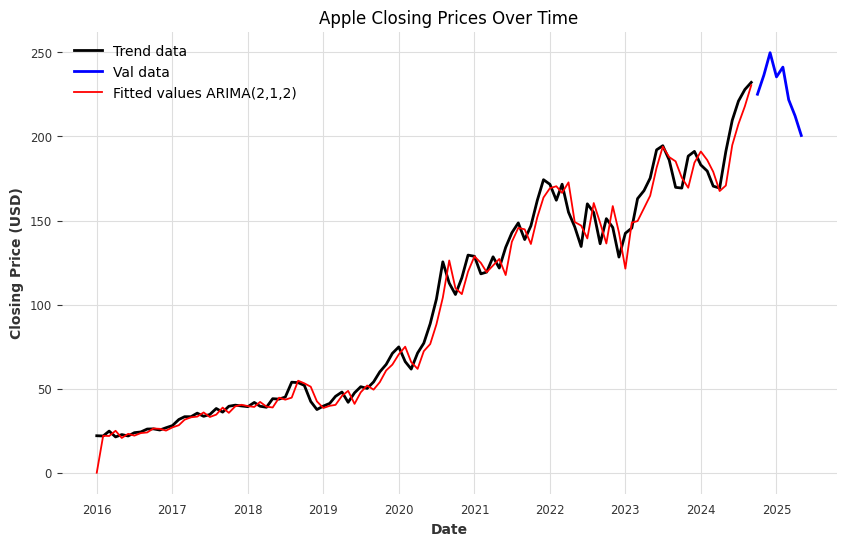

In [302]:
#Graficamos la serie temporal con los datos de entrenamiento y validación
plt.figure(figsize=(10, 6))
apple_train.plot(color='black', label='Trend data')
apple_val.plot(color = 'blue', label='Val data')
plt.plot(df.index[:105], mod1.fittedvalues, label = 'Fitted values ARIMA(2,1,2)', color = 'red' )
plt.title('Apple Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [303]:
pred1 = mod1.get_forecast(steps=8).predicted_mean
MSE1 = mean_squared_error(apple_val_pd, pred1)
rmse1 = np.sqrt(MSE1)
rmse1

16.042679713888322

In [304]:
rmse0

0    22.190807
dtype: float64

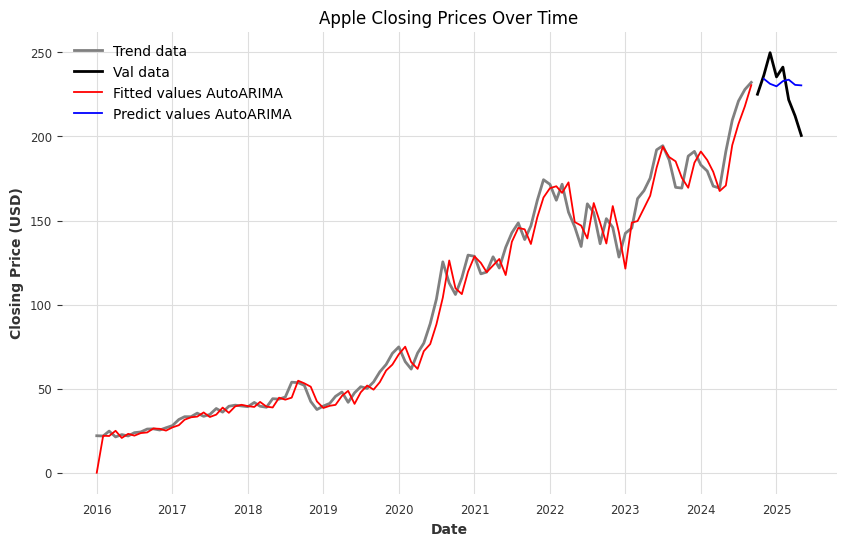

In [305]:
#Graficamos la serie temporal con los datos de entrenamiento y validación
plt.figure(figsize=(10, 6))
apple_train.plot(color='gray', label='Trend data')
apple_val.plot(color = 'black', label='Val data')
plt.plot(df.index[:105], mod1.fittedvalues, label = 'Fitted values AutoARIMA', color = 'red' )
plt.plot(df.index[106:], pred1[0:7], label = 'Predict values AutoARIMA', color='blue')
plt.title('Apple Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()